In [105]:
import numpy as np
import matplotlib.pylab as plt
import glob
from scipy import signal
import scipy
import os
from scipy.optimize import curve_fit

import matplotlib.ticker as mtick


In [59]:
files = sorted(glob.glob('spitfire_osc_wide_window/[0-9]*.csv'))

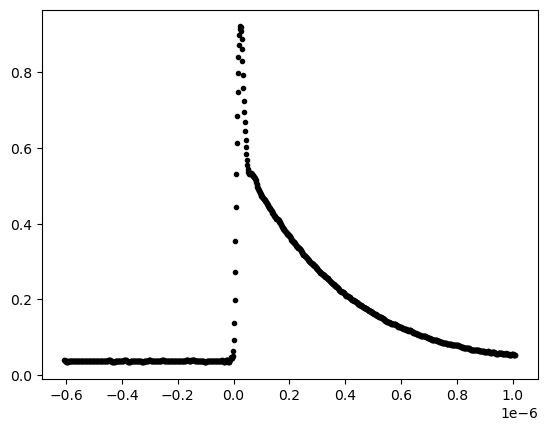

In [60]:
calibration =  np.loadtxt('spitfire_osc_wide_window/calibration.csv', delimiter = ',').T
plt.plot(*calibration, 'k.', ls = 'None' )

In [61]:
pos_mm = np.array([float(os.path.basename(f).replace('.csv','').replace('_','.')) for f in files])
sig = []

In [62]:
for f in files:
    t, v = np.loadtxt(f,delimiter = ',').T
    sig.append(np.sum(v)/len(v))
sig = np.array(sig)

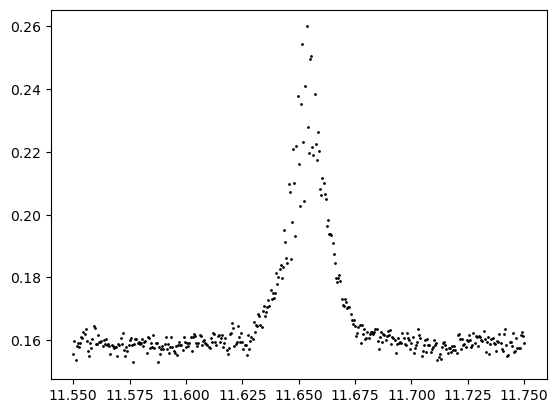

In [63]:
fig = plt.figure()
ax = plt.gca()
ax.plot(pos_mm, sig,'k.', label = 'Data', ms = 2)

In [64]:
def lor(x, x0 ,g):
    return 1/np.pi/g/(1+((x-x0)/g)**2) 

def gau(x, x0, s):
    return 1/np.sqrt(2/np.pi)/s*np.exp(-1/2*(x-x0)**2/s**2) 

def model(x,aL,aG, x0, g,s,C):
    return aG/1000 * gau(x,x0,s)+ C + aL/1000 * lor(x,x0,g)

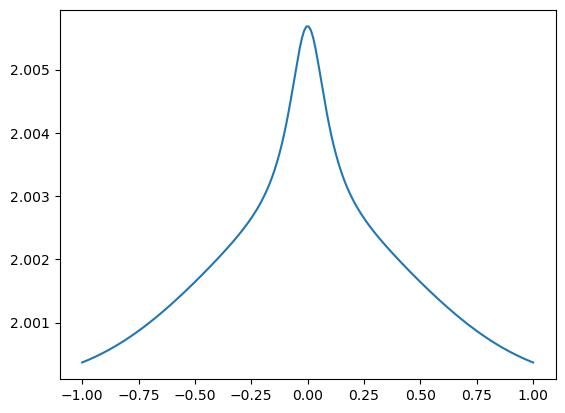

In [65]:
x = np.linspace(-1,1,200)
plt.plot(x, model(x, 1,1,0,.1,.5, 2))

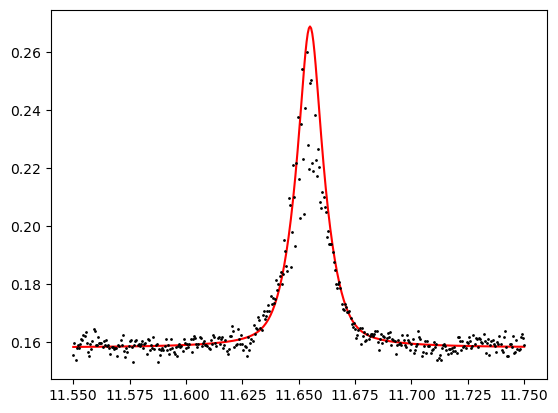

In [66]:

p0 = [1.5,.2, 11.655, .006,.008,.158]
plt.plot(pos_mm, model(pos_mm,*p0),'r-')
plt.plot(pos_mm, sig,'k.', ls = 'None', ms = 2)

In [67]:
fit, err = curve_fit(model, pos_mm, sig, p0=p0, 
                     bounds = ([.2,0.2,11.650, .002,.003,.150],
                    [3,1,11.665, .01,.05,.170]), sigma = 1/sig**3)

aL,aG,x0,g,s,C = fit
fit

array([1.24934352e+00, 2.00000000e-01, 1.16538097e+01, 6.69398435e-03,
       9.55935931e-03, 1.58323700e-01])

In [100]:
t_fs = (pos_mm - fit[2])/1e3/2.998e8/1e-15*2

In [134]:
fwhm_factor = 2.355
width = fit[-2]/1e3/3e8 /1e-15 * 2 
e_width = np.sqrt(np.diag(err))[-2]/1e3/3e8 /1e-15 
print(f'{width:.0f} +/- {e_width:.0f}')

64 +/- 3


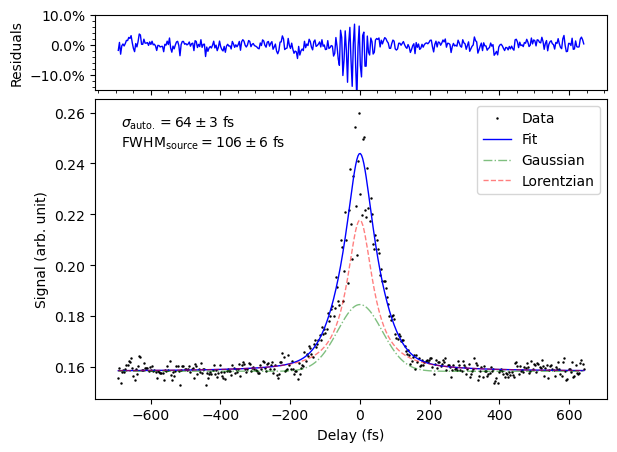

In [145]:
fig = plt.figure()
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


res_ax = fig.add_subplot(gs[0, 0])
ax = fig.add_subplot(gs[1, 0])

ax.plot(t_fs, sig, 'k.', ms = 1.5, markevery=1, label = 'Data')
ax.plot(t_fs, model(pos_mm, *fit), c='b', lw = 1,  label ='Fit')
ax.plot(t_fs, gau(pos_mm, x0, s)*aG/1000+ C, '-.', c = 'green', lw =1, alpha = .5,  label ='Gaussian')
ax.plot(t_fs, lor(pos_mm, x0, g)*aL/1000+ C, '--', c ='r', lw =1, alpha = .5,   label = 'Lorentzian')
ax.set_xlabel('Delay (fs)')
ax.set_ylabel('Signal (arb. unit)')
ax.legend(loc = 0)

res_ax.plot(t_fs, (sig - model(pos_mm, *fit))/sig *100, 'b-', lw = 1)
res_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
res_ax.minorticks_on()
res_ax.set_ylim(-15,10)
res_ax.set_ylabel('Residuals')


text_out = "$\sigma_{\mathrm{auto.}}=$" + f"${width:.0f}\pm{e_width:.0f}$ fs\n"+\
"$\mathrm{FWHM}_{\mathrm{source}}=$" + f"${width/np.sqrt(2) * fwhm_factor:.0f}\pm{e_width/np.sqrt(2) *fwhm_factor:.0f}$ fs\n"

ax.text(.05,.95, s = text_out, transform = ax.transAxes, va = 'top')

fig.savefig('../figures/spitfire.pdf', format= 'pdf', bbox_inches= 'tight')

In [71]:
Lc = fit[-3]/1e3/3e8 /1e-15 * 2
e_Lc = np.sqrt(np.diag(err))[-3]/1e3/3e8 /1e-15
print(f'{Lc:.3f} +/- {e_Lc:.3f}')

44.627 +/- 3.412


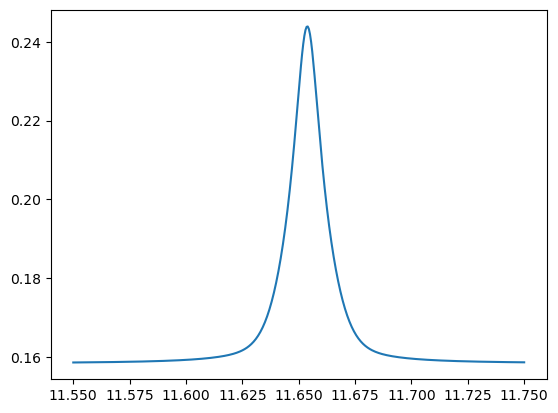

In [72]:
yy = model(pos_mm, *fit)
plt.plot(pos_mm, yy)